<a href="https://colab.research.google.com/github/pedro00pt/Projeto-de-Big-Data/blob/main/Projeto_de_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto de Big Data**

**Realizado por:**
**Pedro Peixoto nº202000221** **e**
**João Yanga nº202000167**

O código apresentado de seguida serve para instalar o pyspark.

In [144]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


O código apresentado de seguida serve para importar as bibliotecas necessárias para o nosso programa.

In [145]:
from pyspark.sql.functions import col, udf, count, asc, desc
from pyspark.sql.types import DoubleType, IntegerType, DateType, FloatType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

O código que aparece de seguida serve para inicializar uma SparkSession.
Atribuiu-se o nome à nossa aplicação: Projeto de Big Data. 

In [146]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

spark = SparkSession.builder.appName("Projeto de Big Data")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()




spark

De seguida, foi lido o ficheiro csv que continha os dados do dataset escolhido.

In [147]:
!curl https://raw.githubusercontent.com/pedro00pt/Projeto-de-Big-Data/main/bank_transactions-colunas_alinhadas.csv >> bank_transactions-colunas_alinhadas.csv
df = spark.read.csv('bank_transactions-colunas_alinhadas.csv',header=True,sep=";")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.8M  100 66.8M    0     0   167M      0 --:--:-- --:--:-- --:--:--  167M


Retorna as 10 primeiras linhas do dataframe:

In [148]:
df.head(10)

[Row(TransactionID='T1', CustomerID='C5841053', CustomerDOB='10/1/94', CustGender='F', CustLocation='JAMSHEDPUR', CustAccountBalance='17819.05', TransactionDate='02/08/2016', TransactionTime='143207', TransactionAmount (INR)='25'),
 Row(TransactionID='T2', CustomerID='C2142763', CustomerDOB='4/4/57', CustGender='M', CustLocation='JHAJJAR', CustAccountBalance='2270.69', TransactionDate='02/08/2016', TransactionTime='141858', TransactionAmount (INR)='27999'),
 Row(TransactionID='T3', CustomerID='C4417068', CustomerDOB='26/11/96', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='17874.44', TransactionDate='02/08/2016', TransactionTime='142712', TransactionAmount (INR)='459'),
 Row(TransactionID='T4', CustomerID='C5342380', CustomerDOB='14/9/73', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='866503.21', TransactionDate='02/08/2016', TransactionTime='142714', TransactionAmount (INR)='2060'),
 Row(TransactionID='T5', CustomerID='C9031234', CustomerDOB='24/3/88', CustGe

Mostra as 5 primeiras linhas do dataframe no formato de uma tabela com linhas e colunas:

In [149]:
df.show(5,0)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|T1           |C5841053  |10/1/94    |F         |JAMSHEDPUR  |17819.05          |02/08/2016     |143207         |25                     |
|T2           |C2142763  |4/4/57     |M         |JHAJJAR     |2270.69           |02/08/2016     |141858         |27999                  |
|T3           |C4417068  |26/11/96   |F         |MUMBAI      |17874.44          |02/08/2016     |142712         |459                    |
|T4           |C5342380  |14/9/73    |F         |MUMBAI      |866503.21         |02/08/2016     |142714         |2060                   |
|T5           |C9031234  |24/3/88 

# **Exploração e Tratamento de dados**

Informações gerais do dataframe:
*   Número de linhas
*   Número de TransactionID's distintos
*   Número de CustomerID's distintos

Verificou-se que várias colunas eram do tipo string quando não o deveriam ser, visto que tratam-se de dados bancários como o saldo da conta e o montante de transação. Fizeram-se então as devidas alterações dos tipos de dados.
Viu-se de seguida se as colunas do dataframe contêm valores nulos e na's.

In [150]:
df.count()

5242839

In [151]:
df.select('TransactionID').distinct().count()

1048568

In [152]:
df.select('CustomerID').distinct().count()

884266

In [153]:
df = df \
    .withColumn('CustomerDOB', col('CustomerDOB').cast(DateType())) \
    .withColumn('CustAccountBalance', col('CustAccountBalance').cast(FloatType())) \
    .withColumn('TransactionDate', col('TransactionDate').cast(DateType())) \
    .withColumn('TransactionTime', col('TransactionTime').cast(IntegerType())) \
    .withColumn('TransactionAmount (INR)', col('TransactionAmount (INR)').cast(FloatType()))

In [155]:
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|      5500|         755|             11849|              4|                      4|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



In [156]:
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(isnan(c), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|         0|           0|                 0|              0|                      0|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



Foram retirados os valores nulos das colunas CustAccountBalance e TransactionAmount (INR).

In [157]:
from pyspark.sql.functions import col

df = df.filter(col("CustAccountBalance").isNotNull())

In [158]:
from pyspark.sql.functions import col

df = df.filter(col("TransactionAmount (INR)").isNotNull())

In [159]:
df.describe().show()

+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|summary|TransactionID|CustomerID|CustGender|        CustLocation|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|  count|      5230990|   5230990|   5225490|             5230235|           5230990|           5230990|                5230990|
|   mean|         null|      null|      null|            400012.0|115403.54003532637|157093.97752911015|     1573.2668660781376|
| stddev|         null|      null|      null|                 0.0| 846485.0576792513|51262.197489018334|      6569.712619439309|
|    min|           T1|  C1010011|         F|(154) BHASKOLA FA...|               0.0|                 0|                    0.0|
|    max|      T999999|  C9099956|         T|           ZUNHEBOTO|      1.15035496E8|            

In [160]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): float (nullable = true)



In [161]:
print(dict(df.dtypes)['CustAccountBalance'] )

float


In [162]:
print(dict(df.dtypes)['TransactionID'] )

string


In [163]:
df_id_CustomerID = df.select('CustomerID')

In [164]:
df_id_CustomerID.show(3)

+----------+
|CustomerID|
+----------+
|  C5841053|
|  C2142763|
|  C4417068|
+----------+
only showing top 3 rows



In [165]:
df.columns

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount (INR)']

In [166]:
df_id_CustGender = df.select('CustGender')

In [167]:
df_id_CustGender.show(10)

+----------+
|CustGender|
+----------+
|         F|
|         M|
|         F|
|         F|
|         F|
|         F|
|         F|
|         M|
|         F|
|         M|
+----------+
only showing top 10 rows



In [168]:
new_df_CustAccountBalanceBiggerThan5000 = df.filter(df.CustAccountBalance > 5000)
new_df_CustAccountBalanceBiggerThan5000.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053|       null|         F|  JAMSHEDPUR|          17819.05|           null|         143207|                   25.0|
|           T3|  C4417068|       null|         F|      MUMBAI|          17874.44|           null|         142712|                  459.0|
|           T4|  C5342380|       null|         F|      MUMBAI|          866503.2|           null|         142714|                 2060.0|
|           T5|  C9031234|       null|         F| NAVI MUMBAI|           6714.43|           null|         181156|                 1762.5|
|           T6|  C1536588|       n

In [169]:
new_df_TransactionTimeLessThan500 = df.filter(df.TransactionTime < 500)
new_df_TransactionTimeLessThan500.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|        T5126|  C1214190|       null|         F|        DURG|            401.44|           null|            400|                  110.0|
|       T20397|  C3222875|       null|         M|  VIJAYAWADA|          16511.74|           null|             10|                  330.0|
|       T21305|  C6228180|       null|         M|    DINDIGUL|             70.09|           null|            113|                   10.0|
|       T35040|  C8916035|       null|         M|   BANGALORE|          19298.99|           null|            357|                1538.81|
|       T35041|  C6432239|       n

In [170]:
df.select('CustGender').distinct().count()

4

In [171]:
new_df_PessoasPorSexo = df.groupby('CustGender')
new_df_PessoasPorSexo.count().show(10)

+----------+-------+
|CustGender|  count|
+----------+-------+
|         F|1406360|
|      null|   5500|
|         T|      5|
|         M|3819125|
+----------+-------+



In [173]:
new_df_CustLocation = df.groupby('CustLocation')
new_df_CustLocation.count().show(20)

+--------------------+-----+
|        CustLocation|count|
+--------------------+-----+
|             GWALIOR| 4735|
|      UTTAR DINAJPUR|  310|
|             SANGRUR| 1760|
|  ACADEMY SAMASTIPUR|   25|
|NO 3 NR LALLAN HO...|  285|
|GATE DARIYAPUR AH...|   35|
|ELPHINSTONE W MUMBAI|   60|
|             SHIMOGA|  570|
|          FLOOR PUNE|   10|
|           TIRUVALLA|   40|
|        SARAN CHAPRA|   15|
|             MOHANIA|   10|
|              TEEKOY|   50|
|CUMBALLA HILL MUMBAI|   10|
|            KANUBARI|  120|
|          NALAPPURAM|   25|
|B/H ATM UNION BAN...|   25|
|  TIRUPATI NGR THANE|   10|
|            K K DIST|   50|
|              SUBBAL|   15|
+--------------------+-----+
only showing top 20 rows



In [174]:
df.groupBy('CustLocation').agg(countDistinct('CustomerID').alias('count')).orderBy(desc('count')).show(10)

+------------+------+
|CustLocation| count|
+------------+------+
|      MUMBAI|101473|
|   NEW DELHI| 83371|
|   BANGALORE| 80264|
|     GURGAON| 72788|
|       DELHI| 69870|
|       NOIDA| 32493|
|     CHENNAI| 29749|
|        PUNE| 25632|
|   HYDERABAD| 22889|
|       THANE| 21336|
+------------+------+
only showing top 10 rows



In [175]:
df.createOrReplaceTempView("Top80AccountBalance")
query = '''SELECT CustomerID, CustGender, CustLocation, CustAccountBalance FROM Top80AccountBalance ORDER BY CustAccountBalance DESC'''
spark.sql(query).show(80)

+----------+----------+------------+------------------+
|CustomerID|CustGender|CustLocation|CustAccountBalance|
+----------+----------+------------+------------------+
|  C4316889|         M|    SHILLONG|      1.15035496E8|
|  C2916865|         M|    SHILLONG|      1.15035496E8|
|  C8116818|         M|    SHILLONG|      1.15035496E8|
|  C2216823|         M|    SHILLONG|      1.15035496E8|
|  C2916887|         M|    SHILLONG|      1.15035496E8|
|  C2916887|         M|    SHILLONG|      1.15035496E8|
|  C7716886|         M|    SHILLONG|      1.15035496E8|
|  C3316830|         M|    SHILLONG|      1.15035496E8|
|  C6416825|         M|    SHILLONG|      1.15035496E8|
|  C5916881|         M|    SHILLONG|      1.15035496E8|
|  C2916865|         M|    SHILLONG|      1.15035496E8|
|  C6416825|         M|    SHILLONG|      1.15035496E8|
|  C2216823|         M|    SHILLONG|      1.15035496E8|
|  C4316889|         M|    SHILLONG|      1.15035496E8|
|  C2216823|         M|    SHILLONG|      1.1503

In [176]:
top10 = df.groupBy("CustLocation").agg(avg("CustAccountBalance")) \
          .orderBy(avg("CustAccountBalance"), ascending=False) \
          .limit(10)
top10.createOrReplaceTempView("temp_view")
top10.show()

+--------------------+-----------------------+
|        CustLocation|avg(CustAccountBalance)|
+--------------------+-----------------------+
|  PO BOX 28483 DUBAI|             2.169666E7|
|              RENTON|            2.0773104E7|
|   SULTANATE OF OMAN|            1.6599123E7|
|MERCEDES SHOWROOM...|              7567497.5|
|            SHILLONG|      7240424.006631125|
|              AHMADI|              7090440.5|
|SOMAJIGUDA HYDERABAD|              6503694.0|
|       BORIVALI WEST|              6011185.5|
|              SAKAKA|              5441524.5|
|(W) NEAR RAMDEV M...|              5208462.5|
+--------------------+-----------------------+



In [177]:
#alteração do nome da coluna: de TransactionAmount (INR) para TransactionAmount 

df = df.withColumnRenamed('TransactionAmount (INR)', 'TransactionAmount')

In [178]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount: float (nullable = true)



In [179]:
new_df_TransactionAmountLessThan1000 = df.filter(df.TransactionAmount < 1000)
new_df_TransactionAmountLessThan1000.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------+
|           T1|  C5841053|       null|         F|  JAMSHEDPUR|          17819.05|           null|         143207|             25.0|
|           T3|  C4417068|       null|         F|      MUMBAI|          17874.44|           null|         142712|            459.0|
|           T6|  C1536588|       null|         F|    ITANAGAR|           53609.2|           null|         173940|            676.0|
|           T7|  C7126560|       null|         F|      MUMBAI|            973.46|           null|         173806|            566.0|
|           T8|  C1220223|       null|         M|      MUMBAI|          9507

In [180]:
df.createOrReplaceTempView("Top50TransactionAmount")
query = '''SELECT CustomerID, CustGender, CustLocation, CustAccountBalance, TransactionAmount FROM Top50TransactionAmount ORDER BY TransactionAmount DESC'''
spark.sql(query).show(50)

+----------+----------+-----------------+------------------+-----------------+
|CustomerID|CustGender|     CustLocation|CustAccountBalance|TransactionAmount|
+----------+----------+-----------------+------------------+-----------------+
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C6677159|         F|             PUNE|          98660.33|        1380002.9|
|  C6677159|         F|             PUNE|          98660.33|        1380002.9|
|  C6677159|         F|             PUNE|          98660.33|        1380002.9|
|  C6677159|         F|             PUNE|          98660.33|        1380002.9|
|  C6677159|         F|             PUNE|          9

In [181]:
df.describe().toPandas()

,summary,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount
0,count,5230990,5230990,5225490,5230235,5230990,5230990,5230990
1,mean,None,None,None,400012.0,115403.54003532637,157093.97752911015,1573.2668660781376
2,stddev,None,None,None,0.0,846485.0576792513,51262.197489018334,6569.712619439309
3,min,T1,C1010011,F,(154) BHASKOLA FARIDABAD,0.0,0,0.0
4,max,T999999,C9099956,T,ZUNHEBOTO,1.15035496E8,235959,1560035.0


Gráfico circular relativo ao sexo dos clientes:

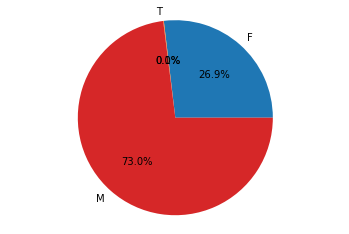

In [182]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Agrupando as contagens de gênero
gender_counts = df.groupBy("CustGender").count()

# Extraindo os dados como listas
genders = gender_counts.select("CustGender").rdd.flatMap(lambda x: x).collect()
counts = gender_counts.select("count").rdd.flatMap(lambda x: x).collect()

# Criando o gráfico circular
plt.pie(counts, labels=genders, autopct='%1.1f%%')
plt.axis('equal')
plt.show()


Os valores que perfazem 0.1% são nulos. 73% dos clientes do banco são do sexo masculino, 26.9% são do sexo feminino. A letra T no gráfico é relativo aos clientes do banco que não se identificam com nenhum dos dois géneros mencionados acima.

**Algoritmo de K-means**

In [183]:
# Cria um vetor assembler para combinar as colunas "CustAccountBalance" e "TransactionAmount" em um único vetor
vectorAssembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="unscaled_features")

# Utiliza o vetor assembler para transformar o DataFrame
df_kmeans = vectorAssembler.transform(df)

# Cria um objeto de escalonamento para standardizar os dados
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)

# Ajusta o escalonador aos dados e transforma o DataFrame
scalerModel = scaler.fit(df_kmeans)
df_kmeans = scalerModel.transform(df_kmeans)

# Instancia o modelo KMeans com o número de clusters desejado
kmeans = KMeans(k=3, seed=1)

# Ajusta o modelo aos dados
model = kmeans.fit(df_kmeans)

# Faz a previsão dos clusters
predictions = model.transform(df_kmeans)

# Exibe os resultados
predictions.select("CustAccountBalance", "TransactionAmount","prediction").show()

+------------------+-----------------+----------+
|CustAccountBalance|TransactionAmount|prediction|
+------------------+-----------------+----------+
|          17819.05|             25.0|         0|
|           2270.69|          27999.0|         0|
|          17874.44|            459.0|         0|
|          866503.2|           2060.0|         0|
|           6714.43|           1762.5|         0|
|           53609.2|            676.0|         0|
|            973.46|            566.0|         0|
|          95075.54|            148.0|         0|
|          14906.96|            833.0|         0|
|           4279.22|           289.11|         0|
|          48429.49|            259.0|         0|
|          14613.46|            202.0|         0|
|          32274.78|          12300.0|         0|
|          59950.44|             50.0|         0|
|          10100.84|            338.0|         0|
|           1283.12|            250.0|         0|
|          77495.15|          1423.11|         0|


Se as previsões de clusters de um output de k-means têm valores de 0, isso pode indicar que os dados associados a essas previsões não foram atribuídos a nenhum cluster. Isso pode acontecer se os dados não se encaixarem em nenhum dos clusters criados pelo algoritmo, ou se o algoritmo não conseguiu encontrar nenhum cluster significativo nos dados.

**Algoritmo de Regressão Linear**

In [184]:
# Cria o objeto VectorAssembler para combinar as colunas em uma única coluna de vetores
assembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="features2")

# Ajusta o assembler ao seu dataframe
df_vec = assembler.transform(df)

# Cria o objeto StandardScaler
scaler = StandardScaler(inputCol="features2", outputCol="scaledFeatures", withStd=True, withMean=True)

# Ajusta o scaler ao seu dataframe
scaled_df = scaler.fit(df_vec).transform(df_vec)


In [185]:
from pyspark.ml.regression import LinearRegression

# Cria o objeto LinearRegression
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="CustAccountBalance", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Dividindo o dataframe em conjunto de treinamento e teste
train_df, test_df = scaled_df.randomSplit([0.9, 0.1])

# Treinando o modelo
model = lr.fit(train_df)

# Testando o modelo
predictions = model.transform(test_df)


In [186]:
# Aplicando o modelo aos dados de teste
predictions = model.transform(test_df)

# Visualizando as previsões
predictions.select("prediction").show()


+------------------+
|        prediction|
+------------------+
| 57477.30969112188|
|29521.630212340053|
|184938.77202648125|
| 9257.717520452788|
| 5.651134143059608|
|  324498.706607711|
| 223030.4771856923|
|  7309.02876260296|
|2282.6902239255724|
| 328.3010286564968|
| 36566.10621455732|
| 6132.768928375997|
|  937077.331794988|
|  89396.0561152909|
| 25803.52216392866|
| 50156.15214699719|
| 209789.9037848137|
| 118701.8269092469|
|18.701129200853757|
|1031.8907434421417|
+------------------+
only showing top 20 rows



In [189]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="rmse")

# Calcular o RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.318969


In [190]:
# Acessando o resumo do modelo
summary = model.summary

# Obtendo o R²
r2 = summary.r2

# Exibindo o R²
print("R-squared value:", r2)


R-squared value: 0.9999999999998727


In [191]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mae")

# Calcular o MAE
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)


Mean Absolute Error (MAE) on test data = 0.0566807


In [192]:
# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mse")

# Calcular o MSE
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Mean Squared Error (MSE) on test data = 0.101741


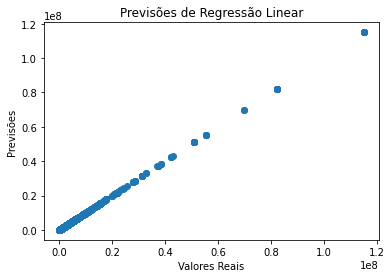

In [193]:
import matplotlib.pyplot as plt

# Extrair as colunas de previsão e rótulo do dataframe de previsões
predictions_col = predictions.select("prediction").toPandas()
label_col = predictions.select("CustAccountBalance").toPandas()

# Plotar as previsões em relação aos valores reais
plt.scatter(label_col, predictions_col)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Previsões de Regressão Linear")
plt.show()